In [1]:
'''
Related papers:

1.https://openaccess.thecvf.com/content_CVPR_2020/papers/Liu_ABCNet_Real-Time_Scene_Text_Spotting_With_Adaptive_Bezier-Curve_Network_CVPR_2020_paper.pdf
2.https://arxiv.org/abs/1901.03781
3.Line Segment Detection Using Transformers without Edge [https://arxiv.org/pdf/2101.01909v1.pdf]

Dataset:
(1242 images / 500x500 / ../DATA)
https://openaccess.thecvf.com/content/ACCV2020/html/Abdelfattah_TTPLA_An_Aerial-Image_Dataset_for_Detection_and_Segmentation_of_Transmission_ACCV_2020_paper.html
'''

'\nRelated papers:\n\n1.https://openaccess.thecvf.com/content_CVPR_2020/papers/Liu_ABCNet_Real-Time_Scene_Text_Spotting_With_Adaptive_Bezier-Curve_Network_CVPR_2020_paper.pdf\n2.https://arxiv.org/abs/1901.03781\n3.Line Segment Detection Using Transformers without Edge [https://arxiv.org/pdf/2101.01909v1.pdf]\n\nDataset:\n(1242 images / 500x500 / ../DATA)\nhttps://openaccess.thecvf.com/content/ACCV2020/html/Abdelfattah_TTPLA_An_Aerial-Image_Dataset_for_Detection_and_Segmentation_of_Transmission_ACCV_2020_paper.html\n'

In [1]:
#imports

import os
#restrict gpu usage
os.environ["CUDA_VISIBLE_DEVICES"]="3"

from PIL import Image
import cv2
import bezier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle

# setting theme
px = 1/plt.rcParams['figure.dpi']
#sns.set(style=None, rc={'figure.figsize':(256*px, 256*px)})

# generate random floating point values
from numpy.random import seed, rand, randint
from random import gauss

In [2]:
# avoid printing images
#%matplotlib agg

In [175]:
# Create me a dataset

#[pixeldata, vectordata, length, label]
raw = []

def create_dataset():
    for _ in range(500):
        
        cpgen = rand(2, 2)
        sizer = randint(2,10,2)
        #plt.rcParams["figure.figsize"] = (sizer)

        nodes1 = np.asfortranarray(cpgen)
        curve1 = bezier.Curve(nodes1, degree=1)
        ax = curve1.plot(num_pts=256)
        ax.set(xlim=(0, 1), ylim=(0, 1))
        ax.set_axis_off()

        fig2 = plt.figure()
        fig2.axes.append(ax)
        
        #plt.show()
        path = "./custom/images/li_{}.jpg".format(_)
        
        #save image
        ax.figure.savefig(path, dpi=None)
        
        size = fig2.get_size_inches()*fig2.dpi # size in pixels
        w, h = size
        
        cap_data = np.array([nodes1, w, h, curve1.length], dtype="object")
        raw.append(cap_data)
        
        plt.close('all')
    
#create_dataset()
'''
ax = curve1.plot(num_pts=256)
ax.axis("off")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#ax.figure.savefig('out.png', bbox_inches='tight', pad_inches=0)
'''


'\nax = curve1.plot(num_pts=256)\nax.axis("off")\nax.get_xaxis().set_visible(False)\nax.get_yaxis().set_visible(False)\n#ax.figure.savefig(\'out.png\', bbox_inches=\'tight\', pad_inches=0)\n'

In [2]:
# returns data upon filename

def ind_return(filename):
    #print(filename)
    idx_s = filename.split("_")
    idx_s = idx_s[1].split(".")
    idx_n = int(idx_s[0])
    return idx_n
    
#ind_return("li_2.jpeg")

In [181]:
# for xml generation
import xml.etree.cElementTree as ET

def xmlgen(foln, fn, path, a_path, width, height, xmin, ymin, xmax, ymax):

    root = ET.Element("annotation")
    folder = ET.SubElement(root, "folder").text = foln
    filename = ET.SubElement(root, "filename").text = fn
    path = ET.SubElement(root, "path").text = path
    source = ET.SubElement(root, "source") 
    
    ET.SubElement(source, "database").text = "unknown"
    
    size = ET.SubElement(root, "size")

    ET.SubElement(size, "width").text = width
    ET.SubElement(size, "height").text = height
    
    segmented = ET.SubElement(root, "segmented").text = "0"
    _object = ET.SubElement(root, "_object")
    
    ET.SubElement(_object, "name").text = fn
    ET.SubElement(_object, "pose").text = "Unspecified"
    ET.SubElement(_object, "truncated").text = "0"
    ET.SubElement(_object, "difficult").text = "0"
    
    bndbox = ET.SubElement(_object, "bndbox")
    
    ET.SubElement(bndbox, "xmin").text = xmin
    ET.SubElement(bndbox, "ymin").text = ymin
    ET.SubElement(bndbox, "xmax").text = xmax
    ET.SubElement(bndbox, "ymax").text = ymax

    tree = ET.ElementTree(root)
    tree.write(a_path)

# get all raw images 
def xmlmaker():
    for i in range(len(raw)):
        box, w, h, length = raw[i]
        x, y = box
        xmin = str(x[0])
        ymin = str(x[1])
        xmax = str(y[0])
        ymax = str(y[1])
        width = str(w)
        height = str(h)

        foln = "custom"
        fn = "li_{}".format(i)
        path = "{}/images/{}.jpg".format(foln, fn)
        a_path = "{}/annots/{}.xml".format(foln, fn)
        xmlgen(foln, fn, path, a_path,  width, height, xmin, ymin, xmax, ymax)
        
#xmlmaker()

In [18]:
# split into train and test set
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# Dataset object for Mask RCNN

# class that defines and loads the kangaroo dataset
class LineDataset(Dataset):
    
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "line")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            #image_id = filename[:-4]
            image_id = ind_return(filename)
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            path, dirs, files = next(os.walk(images_dir))
            total_files = len(files)
            #print("total_files", total_files)
            train_p = total_files * 80 / 100
            if is_train and int(image_id) >= train_p:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < train_p:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + "li_{}".format(image_id) + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = float(box.find('xmin').text)
            ymin = float(box.find('ymin').text)
            xmax = float(box.find('xmax').text)
            ymax = float(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(float(root.find('.//size/width').text))
        height = int(float(root.find('.//size/height').text))
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('line'))
        return masks, asarray(class_ids, dtype='int32')
    
    def get_boxes_by_id(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        print(path)
        # load XML
        boxes, w, h = self.extract_boxes(path)
        return boxes, w, h
        
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = LineDataset()
train_set.load_dataset('custom', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = LineDataset()
test_set.load_dataset('custom', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 400
Test: 100


self.image_info {'id': 213, 'source': 'dataset', 'path': 'custom/images/li_213.jpg', 'annotation': 'custom/annots/li_213.xml'}
custom/annots/li_213.xml
[0.09609302419872656, 0.35429339606237875, 0.9900000943368246, 0.5366333512920722]
0.09609302419872656 0.35429339606237875 0.9900000943368246 0.5366333512920722


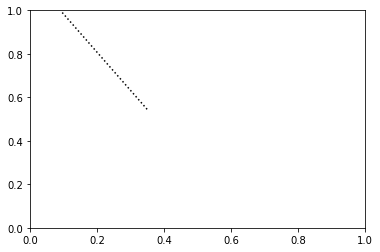

In [40]:
def test2():
    index = 1
    
    fig, ax = plt.subplots()
    '''
    image = train_set.load_image(index)
    ax.imshow(image)
    '''
    raw_boxes, w, h = train_set.get_boxes_by_id(index)
    raw_boxes = raw_boxes[0]
    print(raw_boxes)
    a = raw_boxes[0]
    b = raw_boxes[1]
    c = raw_boxes[2]
    d = raw_boxes[3]
    #print(a,b,c,d)
    ax.plot([a,b], [c,d], color='black', linestyle='dotted')
    ax.set(xlim=(0, 1), ylim=(0, 1))
    plt.show()
    
test2()